# Homework 3 #2: Implement EM algorithm

## Part A: Parse and Plot datapoints

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
data = np.loadtxt("faithful.txt")
df = pd.DataFrame(data=data, columns=["index", "eruptions", "waiting"])
df = df.drop("index", axis=1)
df

,eruptions,waiting
0,3.600,79.0
1,1.800,54.0
2,3.333,74.0
3,2.283,62.0
4,4.533,85.0
...,...,...
267,4.117,81.0
268,2.150,46.0
269,4.417,90.0
270,1.817,46.0


In [24]:
X = df.to_numpy()[:,:2]

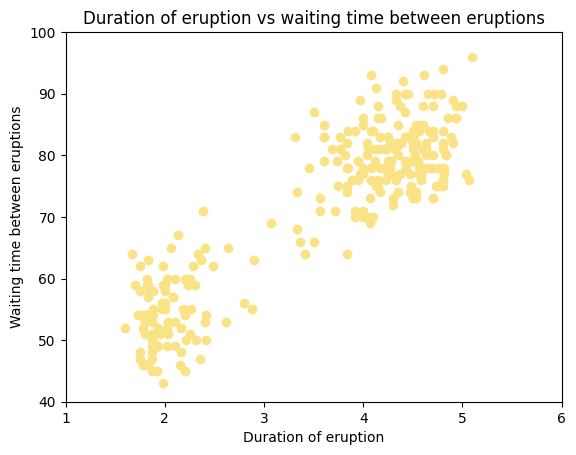

In [25]:
plt.scatter(X[:, 0], X[:, 1], color='#fae387')
plt.xlim([1, 6])
plt.ylim([40, 100])
plt.xlabel('Duration of eruption')
plt.ylabel('Waiting time between eruptions')
plt.title('Duration of eruption vs waiting time between eruptions')
plt.show()

## Part B: Expression for $P_{θ_t}(z=k\mid x)$ in E-step

$P_{θ_t}(z=k\mid x) = \cfrac{P_{θ_t}(z=k, x)}{P_{θ_t}(x)} = \cfrac{P_{θ_t}(x\mid z=k)P_{θ_t}(z=k)}{\sum_{l=1}^K P_{θ_t}(x\mid z=l)P_{θ_t}(z=l)}$ 

## Part C: Formula for $\mu_k, \sum_k$ and $\phi$ in M-step


$\mu_k=\cfrac{\sum_{i=1}^n P(z=k\mid x^{(i)})x^{(i)}}{n_k}$

$\sum_k=\cfrac{\sum_{i=1}^n P(z=k\mid x^{(i)})(x^{(i)}-\mu_k)(x^{(i)}-\mu_k)^\intercal}{n_k}$

$\phi_k=\cfrac{n_k}{n}$

## Part D: Implement and run EM algorithm


### (i) Implement EM

In [26]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [27]:
from scipy.stats import multivariate_normal

def e_step(X, mus, sigmas, phis, n):
    k1_posteriors = np.zeros([n])
    k2_posteriors = np.zeros([n])
    log_pxk = 0
    for i in range(n):
        pxk1 = multivariate_normal(mus[0], sigmas[0]).pdf(X[i]) * phis[0]
        pxk2 = multivariate_normal(mus[1], sigmas[1]).pdf(X[i]) * phis[1]
        sum_k = pxk1 + pxk2
        k1_posteriors[i] = pxk1/sum_k
        k2_posteriors[i] = pxk2/sum_k
        log_pxk += np.log(pxk1 + pxk2)
    return k1_posteriors, k2_posteriors, log_pxk

In [28]:
def get_mus(posteriors, X, n, d, nk):
    sum_n = np.zeros([d])
    for i in range(n):
        sum_n += posteriors[i] * X[i]
    return sum_n/nk

In [29]:
def get_sigmas(posteriors, d, nk, mus):
    sum_n = np.zeros([d])
    sum_n2 = np.zeros([d])

    for i in range(n):
        sum_n += posteriors[i] * (X[i] - mus).dot((X[i] - mus).T)
    return sum_n/nk

In [30]:
def m_step(k1_posteriors, k2_posteriors, X, K, n, d):
    nk1 = sum(k1_posteriors)
    nk2 = sum(k2_posteriors)
    
    mus = np.zeros([K, d])
    sigmas = np.zeros([K, d])
    phis = np.zeros([K])
    
    mus[0] = get_mus(k1_posteriors, X, n, d, nk1)
    mus[1] = get_mus(k2_posteriors, X, n, d, nk2)
    
    sigmas[0] = get_sigmas(k1_posteriors, d, nk1, mus[0])
    sigmas[1] = get_sigmas(k2_posteriors, d, nk2, mus[1])

    phis[0] = nk1/n
    phis[1] = nk2/n
    
    return mus, sigmas, phis

In [31]:
import seaborn as sns


d = 2 # number of features
K = 2 # number of clases
n = X.shape[0] # size of the dataset

# np.random.seed(0)
mus = np.random.random([K, d])
sigmas = np.random.random([K, d])
phis = np.random.random([K])

mu1s = []
mu2s = []

mu1s.append(mus[0])
mu2s.append(mus[1])

marginal_log_likelihood = None

### (ii) Termination Criterion 

In [32]:
while (1):
    # E-step
    e_outputs = e_step(X, mus, sigmas, phis, n)
    k1_posteriors = e_outputs[0]
    k2_posteriors = e_outputs[1]

    # M-step
    mus, sigmas, phis = m_step(k1_posteriors, k2_posteriors, X, K, n, d)
    mu1s.append(mus[0])
    mu2s.append(mus[1])
    
    # Terminates when the difference in two successive marginal log-likelihoods is < 1e-4
    if (marginal_log_likelihood and abs(marginal_log_likelihood - e_outputs[2]) < 0.0001): 
        break
    marginal_log_likelihood = e_outputs[2]

print("Converged after", len(mu1s), "iterations")

Converged after 17 iterations


In [33]:
# Convert scaled data back into original
raw_mu1s = scaler.inverse_transform(mu1s)
raw_mu2s = scaler.inverse_transform(mu2s)
X = scaler.inverse_transform(X)

We calculated the marginal log likelihood for each iteration of the EM algorithm. When the positive difference between the marginal log likelihood in one iteration of EM algorithm and that of the successive iteration is less than 0.0001, our EM algorithm terminates. We chose the threshold of 0.0001 because this difference is small enough to conclude that the marginal log likelihood has converged.

### (iii) Plot trajectories

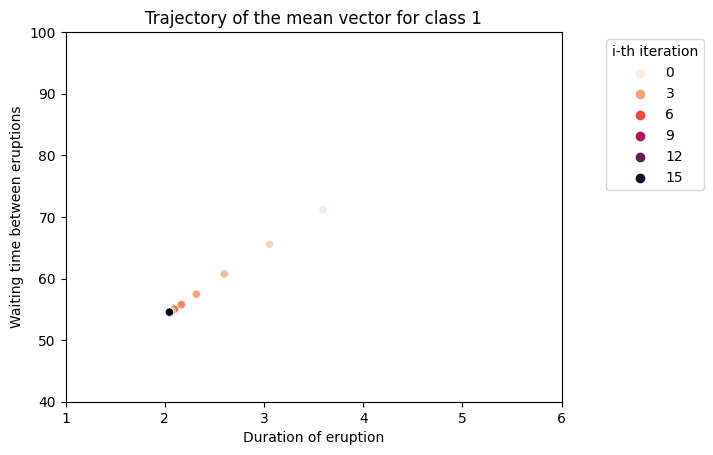

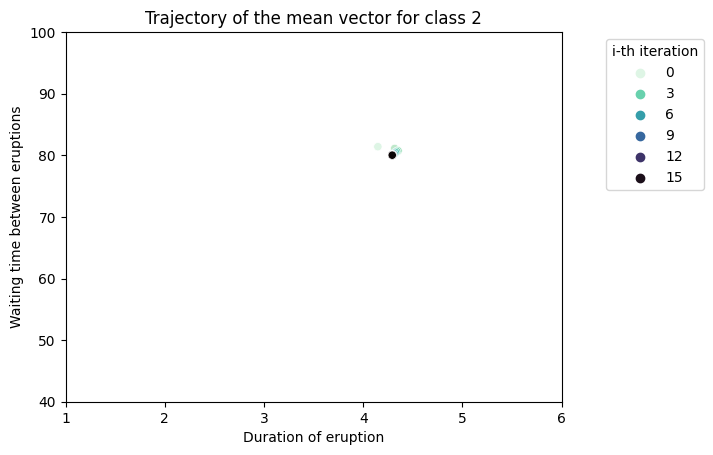

In [34]:
def plot_trajectory(mus, label, color):
    iterations = [i for i in range(len(mus))]
    sns.scatterplot(x=np.asarray(mus)[:, 0], y=np.asarray(mus)[:, 1], 
                    hue=iterations, palette=color)
    plt.xlim([1, 6])
    plt.ylim([40, 100])
    plt.xlabel('Duration of eruption')
    plt.ylabel('Waiting time between eruptions')
    plt.title('Trajectory of the mean vector for ' + label)
    plt.legend(title='i-th iteration', bbox_to_anchor=(1.3,1))
    plt.show()

plot_trajectory(raw_mu1s, 'class 1', 'rocket_r')
plot_trajectory(raw_mu2s, 'class 2', 'mako_r')

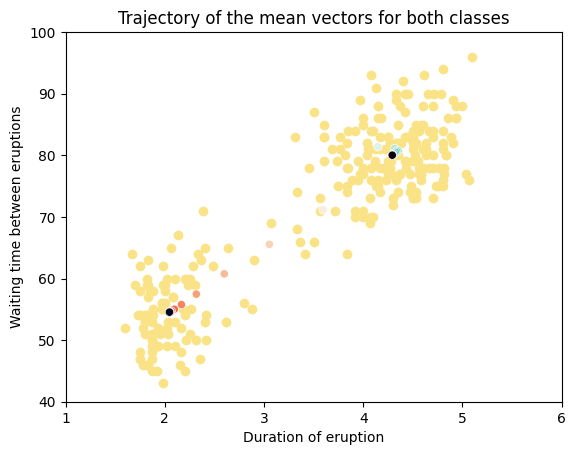

In [35]:
iterations = [i for i in range(len(raw_mu1s))]
plt.scatter(X[:, 0], X[:, 1], color = '#fae387')
ax1 = sns.scatterplot(x=np.asarray(raw_mu1s)[:, 0], y=np.asarray(raw_mu1s)[:, 1], 
                hue=iterations, palette='rocket_r')
ax2 = sns.scatterplot(x=np.asarray(raw_mu2s)[:, 0], y=np.asarray(raw_mu2s)[:, 1], 
                hue=iterations, palette='mako_r')
ax1.get_legend().remove()
plt.xlim([1, 6])
plt.ylim([40, 100])
plt.xlabel('Duration of eruption')
plt.ylabel('Waiting time between eruptions')
plt.title('Trajectory of the mean vectors for both classes')
plt.show()

## Part E: K-Means

In [40]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=K).fit(X)
print('Centroids for K-Means:')
kmeans.cluster_centers_

Centroids for K-Means:


array([[ 4.29793023, 80.28488372],
       [ 2.09433   , 54.75      ]])

In [47]:
print('Centroids for EM:')
np.asarray([raw_mu1s[-1], raw_mu2s[-1]])

Centroids for EM:


array([[ 2.04658907, 54.54411611],
       [ 4.29216408, 80.02421044]])

In [50]:
print('Variances for two clusters in EM:')
phis

Variances for two clusters in EM:


array([0.35820714, 0.64179286])

We ran K-means and got similar centroids for the clusters as our EM algorithm. However, this does not necessarily means that the shapes of our clusters are the same. Because the K-means algorithm assumes that the covariance is zero, the clusters for K-means are sphericial. However, for our EM algorithm, the covariance matrix is a diagonal matrix, meaning that the clusters are ellipses.